# Exploring vector data and finding bounding boxes

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd

from shapely.geometry import box

In this exploration I wanted to start with the extent and the location of the Lago Patillas because I have a good bathymetry map for it. How to come to this data and how you would create a high-quality bathymetry map from survey data [here](https://hatarilabs.com/ih-en/how-to-make-a-lake-bathymetric-map-with-qgis-tutorial).

In [6]:
patillas_shoreline = gpd.read_file('../data/patillas_sample/vector/patillas_shoreline.shp')
patillas_shoreline

,Elevation,geometry
0,67.55,POINT (242914.395 221850.983)
1,67.55,POINT (242914.450 221850.883)
2,67.55,POINT (242915.020 221849.633)
3,67.55,POINT (242915.142 221849.440)
4,67.55,POINT (242915.190 221849.146)
...,...,...
39294,67.55,POINT (242913.331 221850.957)
39295,67.55,POINT (242913.330 221851.001)
39296,67.55,POINT (242914.326 221850.977)
39297,67.55,POINT (242914.365 221851.108)


One of the reasons I work with GeoPandas is that it know how to work with geographical data. For instance it knows how to handle CRS information which helps when switching between different projections.

In [7]:
patillas_shoreline.crs

<Projected CRS: EPSG:6566>
Name: NAD83(2011) / Puerto Rico and Virgin Is.
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Puerto Rico and US Virgin Islands - onshore.
- bounds: (-67.97, 17.62, -64.51, 18.57)
Coordinate Operation:
- name: SPCS83 Puerto Rico & Virgin Islands zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Also, GeoPandas has easy to use interfaces for plotting.

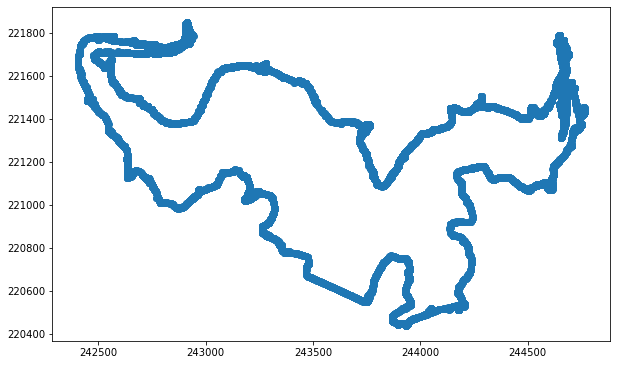

In [8]:
_, ax = plt.subplots(figsize=(10, 10))
patillas_shoreline.plot(ax=ax)
plt.show()

In [9]:
patillas_shoreline.bounds

,minx,miny,maxx,maxy
0,242914.3950,221850.9833,242914.3950,221850.9833
1,242914.4503,221850.8834,242914.4503,221850.8834
2,242915.0200,221849.6333,242915.0200,221849.6333
3,242915.1421,221849.4396,242915.1421,221849.4396
4,242915.1898,221849.1457,242915.1898,221849.1457
...,...,...,...,...
39294,242913.3310,221850.9572,242913.3310,221850.9572
39295,242913.3304,221851.0015,242913.3304,221851.0015
39296,242914.3260,221850.9771,242914.3260,221850.9771
39297,242914.3653,221851.1084,242914.3653,221851.1084


I created a little helper function to get a simple box geometry around all the elements within a geopandas frame. I use this because querying the sentinel API shouldn't be done with an easy "footprint" (not too many nodes in the geometry).

In [10]:
def get_bounding_box(gpd_object, buffer_size=0):
    """
    Returns the bounding box of a geopandas object

    Parameters
    ----------
    gpd_object : geopandas object
        The geopandas object to get the bounding box of
    buffer_size : int
        The buffer size to add to the bounding box

    Returns
    -------
    bounding_box : geopandas series
        The bounding box of the geopandas object
    """
    minx, miny, maxx, maxy = gpd_object.bounds.values.ravel().tolist()
    minx, miny, maxx, maxy = minx - buffer_size, miny - buffer_size, maxx + buffer_size, maxy + buffer_size
    bounding_poly = box(minx, miny, maxx, maxy)
    bounding_series = gpd.GeoSeries([bounding_poly], crs=gpd_object.crs)

    return bounding_series

In [11]:
bounding_box = get_bounding_box(patillas_shoreline, buffer_size=100)

_, ax = plt.subplots(figsize=(10, 10))
bounding_box.plot(ax=ax, color="red")
patillas_shoreline.plot(ax=ax)
plt.show()

ValueError: too many values to unpack (expected 4)

# Exploring bathymetry map

In [ ]:
import rasterio as rio
from rasterio.plot import plotting_extent

import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es

The already existing hiqh-quality bathymetry map can be explored using rasterio.

In [ ]:
with rio.open('../data/patillas_sample/raster/lake_depth.tif') as src:
    bathymetry_map = src.read(masked=True)[0]
    extent = plotting_extent(src)
    soap_profile = src.profile

In [ ]:
ep.plot_bands(bathymetry_map,
               cmap='Blues',
               extent=extent,
               cbar=True);

# Searching sentinel data for Lago Patillas

In [ ]:
import folium
import getpass
import json
import glob

import sentinelsat as sat
from sentinelsat import SentinelAPI, make_path_filter

I chose to visualize the area of interest with folium. The interactive map helps me to compare survey regions with what I get from sentinel. I had to transform the CRS of the bounding box centroid because folium uses ellipsoidal coordinates which are different from the northings/eastings values I have in my current projection.

In [ ]:
lat_long_centroid = bounding_box.centroid.to_crs(epsg=4326)
x, y = lat_long_centroid.x, lat_long_centroid.y
m = folium.Map([y, x], zoom_start=16)
folium.GeoJson(bounding_box.to_crs(epsg=4326).to_json()).add_to(m)
m

The following cells are used to construct the Copernicus Sentinel API client and query the service requesting data with a footprint corresponding to Lago Patillas and a cloud cover percentage of 10% at max. As most of the swaths are over the ocean this percentage is unfortunately not entirely useful as even a little cloud cover is usually covering the land rather than the water.

In [ ]:
copernicus_user = getpass.getpass("Enter your Copernicus username: ")

In [ ]:
copernicus_password = getpass.getpass("Enter your Copernicus password: ")

In [ ]:
api = SentinelAPI(copernicus_user, copernicus_password, 'https://scihub.copernicus.eu/dhus')

In [ ]:
footprint = sat.geojson_to_wkt(json.loads(bounding_box.to_crs(epsg=4326).to_json()))
footprint

In [ ]:
products = api.query(footprint,
                     date = ('20210801', '20211104'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0, 10))

The cells below look at all the products corresponding to the search criteria. They usually cover two areas at different times. Going back further than a couple of months in time would hit the long time archive which only becomes available after a couple of hours after being triggered.

In [ ]:
areas = api.to_geodataframe(products)
areas.plot(column='uuid', cmap=None)

In [ ]:
ax = areas.plot(column='uuid', cmap=None, figsize=(10, 10))
areas.apply(lambda x: ax.annotate(text=x.uuid, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

In [ ]:
_, ax = plt.subplots(1, figsize=(10, 10))
areas.plot(ax=ax,column='uuid', cmap=None,)
bounding_box.to_crs(epsg=4326).plot(ax=ax)
plt.show()

In [ ]:
areas.sort_values(by='cloudcoverpercentage', ascending=False)[["title", "link", "cloudcoverpercentage"]]

After the inspection of a couple of possible products I found one that shows Lago Patillas without being covered by clouds. I still have to find a better way to check for cloud cover over a very tiny area in the whole footprint of a sentinel data product.

In [ ]:
# min_cloudcover_id = areas["cloudcoverpercentage"].idxmin() # we can extract the image with the minimum cloud cover like this
min_cloudcover_id = "8cf4ef49-479c-423a-96d1-d554519dac06" # unfortunately most of the image is water and clouds are over land so we have to visually inspect
nodefilter = make_path_filter("*_B0[2348]_10m.jp2") # for now we only want the 10x10m resolution bands
product_info = api.download(min_cloudcover_id, directory_path='../data/patillas_sample/sentinel/', nodefilter=nodefilter)
product_info

# Exploring, stacking, cropping and exporting sentinel data to a single geoTIFF

In this part I take the acquired raw data and try to stack all bands to get one image and crop everything away that isn't part of the area of interest. In the end, only the area of interest should stay and be accessible in a single multi-band geoTIFF.

In [ ]:
r10m_base = r"..\data\patillas_sample\sentinel\S2A_MSIL2A_20210924T150721_N0301_R082_T19QHV_20210924T192527.SAFE\GRANULE\L2A_T19QHV_A032683_20210924T150723\IMG_DATA\R10m"
r10m_globbing_pattern = f"{r10m_base}/*.jp2"
stack_band_paths = glob.glob(r10m_globbing_pattern)
stack_band_paths.sort()
stack_band_paths

In [ ]:
array, raster_prof = es.stack(stack_band_paths, out_path=r"..\data\patillas_sample\sentinel\S2A_MSIL2A_20210924T150721_N0301_R082_T19QHV_20210924T192527.SAFE\stacked\raster.jp2")
raster_prof

In [ ]:
extent = plotting_extent(array[0], raster_prof["transform"])
extent

In the following plot we can see, that most of the satellite image shows the ocean. Fortunately it seems that our area of interest is cloud free.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
ep.plot_rgb(
    array,
    rgb=[2, 1, 0],
    ax=ax,
    stretch=True,
    extent=extent,
    str_clip=0.5
)
plt.show()

We are only really interested in the Lago Patillas. Because I we have the shape of the shore outline we know the exact extends and can use this as the crop bounds. We make sure to force the CRS of the crop bounds to be the same as of the satellite images to not run into errors.

In [ ]:
with rio.open(stack_band_paths[0]) as raster_crs:
    crop_raster_profile = raster_crs.profile
    crop_bound_projected = patillas_shoreline.to_crs(crop_raster_profile["crs"])

crop_bound_projected

In [ ]:
crop_output_dir = r"..\data\patillas_sample\sentinel\S2A_MSIL2A_20210924T150721_N0301_R082_T19QHV_20210924T192527.SAFE\cropped"

band_paths_list = es.crop_all(
    stack_band_paths, crop_output_dir, crop_bound_projected, overwrite=True
)

After cropping we can stack the cropped bands again and plot the stacked image with the overlayed outline.

In [ ]:
cropped_array, array_raster_profile = es.stack(band_paths_list)
crop_extent = plotting_extent(
    cropped_array[0], array_raster_profile["transform"]
)

# Plotting the cropped image
fig, ax = plt.subplots(figsize=(12, 6))
crop_bound_projected.boundary.plot(ax=ax, color="red", zorder=10)
ep.plot_rgb(
    cropped_array,
    rgb=[2, 1, 0],
    ax=ax,
    stretch=True,
    extent=crop_extent
)
plt.show()

If we're happy at this point we can export the data.

In [ ]:
with rio.open("../data/patillas_sample/raster/patillas_sentinel_l2a_r10m.tif", "w", **array_raster_profile) as dst:
    dst.write(cropped_array)